## Paper Topic Prediction


In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ai_contest/paper/test2/

/content/drive/MyDrive/ai_contest/paper/test2


In [ ]:
!ls

arxivData.json		dataset_paper.csv	 paper_renamed_topic.csv.csv
arxivdataset.zip	manual.csv		 paper_summary.h5
data_clean_final_2.csv	paper_cleaned.csv	 tokenizer_summary.pkl
data_clean_final.csv	paper_one_topic.csv
dataset			paper_renamed_topic.csv


## Import modules

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('dataset_paper.csv', index_col=False)

In [ ]:
data.head()

,title,abstract,topic
0,Reconstructing Subject-Specific Effect Maps,predict model allow subjectspecif infer analyz...,Computer Science
1,Rotation Invariance Neural Network,rotat invari translat invari great valu imager...,Computer Science
2,Spherical polyharmonics and Poisson kernels fo...,introduc develop notion spheric polyharmon ana...,Math & Stats
3,A finite element approximation for the stochas...,stochast landaulifshitzgilbert llg equat coupl...,Math & Stats
4,Comparative study of Discrete Wavelet Transfor...,fouriertransform infrar ftir spectra sampl pla...,Computer Science


In [ ]:
data.topic.value_counts()

AI/ML               12815
Computer Vision     11728
Computer Science    11594
Math & Stats        10001
Physics              7899
Others               3427
Name: topic, dtype: int64

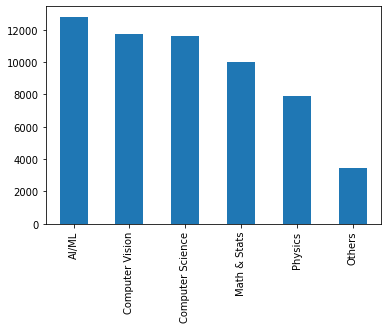

In [ ]:
data.topic.value_counts().plot(kind='bar')

In [ ]:
data = data[data.topic != 'Others']

## Preprocessing

### A. One Hot Encoding

In [ ]:
category = pd.get_dummies(data.topic)
df_new = pd.concat([data, category], axis=1)
df_new = df_new.drop(columns='topic')
df_new.head()

,title,abstract,AI/ML,Computer Science,Computer Vision,Math & Stats,Physics
0,Reconstructing Subject-Specific Effect Maps,predict model allow subjectspecif infer analyz...,0,1,0,0,0
1,Rotation Invariance Neural Network,rotat invari translat invari great valu imager...,0,1,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,introduc develop notion spheric polyharmon ana...,0,0,0,1,0
3,A finite element approximation for the stochas...,stochast landaulifshitzgilbert llg equat coupl...,0,0,0,1,0
4,Comparative study of Discrete Wavelet Transfor...,fouriertransform infrar ftir spectra sampl pla...,0,1,0,0,0


In [ ]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stemmer = PorterStemmer()

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.compile('[/(){}\[\]\|@,;]').sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = re.compile('[\d+]').sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.compile('[^0-9a-z #+_]').sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    #text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # remove single char
    text = re.sub(r"\b[a-zA-Z]\b", "", text)

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    # remove incomplete URL
    text = text.replace("http://", " ").replace("https://", " ")
    
    return text
    
df_new["abstract"] = df_new["abstract"].apply(clean_text)

### B. Pemisahan Features

In [ ]:
df_new.iloc[:, 2:7]

,AI/ML,Computer Science,Computer Vision,Math & Stats,Physics
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0
...,...,...,...,...,...
56453,0,0,0,0,1
56454,0,0,0,0,1
56455,0,0,0,0,1
56456,0,0,0,0,1


In [ ]:
abstract = df_new['abstract']
target = df_new.iloc[:, 2:7]

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
maxlen=-1
for doc in abstract:
    tokens=nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen=len(tokens)
print("Kata maksimal pada document yaitu: ", maxlen)

Kata maksimal pada document yaitu:  290


### C. Split Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(abstract, target, test_size=0.2)

### D. Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='_')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

### E. Padding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_sequence)
X_test_padded = pad_sequences(X_test_sequence)

In [ ]:
len(X_train_padded[0])

290

### F. Embedding + LSTM

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=10000, output_dim=290),
          # tf.keras.layers.Flatten(),
          tf.keras.layers.LSTM(128, dropout=0.5),
          # tf.keras.layers.Dense(128, activation='relu'),
          # tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dropout(0.5),
          # tf.keras.layers.Dense(32, activation='relu'),
          # tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(5, activation='softmax')
        ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 290)         2900000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               214528    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 3,123,109
Trainable params: 3,123,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.72):
      print("\nValidasi Akurasi telah mencapai > 72%")
      self.model.stop_training = True

callbacks= myCallback()

In [ ]:
epoch=50

history = model.fit(X_train_padded, y_train, epochs=epoch,
                    validation_data=(X_test_padded, y_test),
                    batch_size=64, callbacks=[callbacks])

Epoch 1/50
676/676 [==============================] - 692s 1s/step - loss: 1.1268 - accuracy: 0.5536 - val_loss: 0.8651 - val_accuracy: 0.6924
Epoch 2/50
676/676 [==============================] - 646s 955ms/step - loss: 0.8150 - accuracy: 0.7228 - val_loss: 0.8369 - val_accuracy: 0.7145
Epoch 3/50
676/676 [==============================] - 709s 1s/step - loss: 0.7095 - accuracy: 0.7598 - val_loss: 0.8303 - val_accuracy: 0.7187
Epoch 4/50
676/676 [==============================] - 676s 1s/step - loss: 0.6425 - accuracy: 0.7824 - val_loss: 0.8231 - val_accuracy: 0.7253
Epoch 5/50
676/676 [==============================] - 672s 994ms/step - loss: 0.5744 - accuracy: 0.8037 - val_loss: 0.8512 - val_accuracy: 0.7200
Epoch 6/50
676/676 [==============================] - 698s 1s/step - loss: 0.5046 - accuracy: 0.8247 - val_loss: 0.9016 - val_accuracy: 0.7060
Epoch 7/50
676/676 [==============================] - 749s 1s/step - loss: 0.4486 - accuracy: 0.8448 - val_loss: 1.0250 - val_accuracy: 

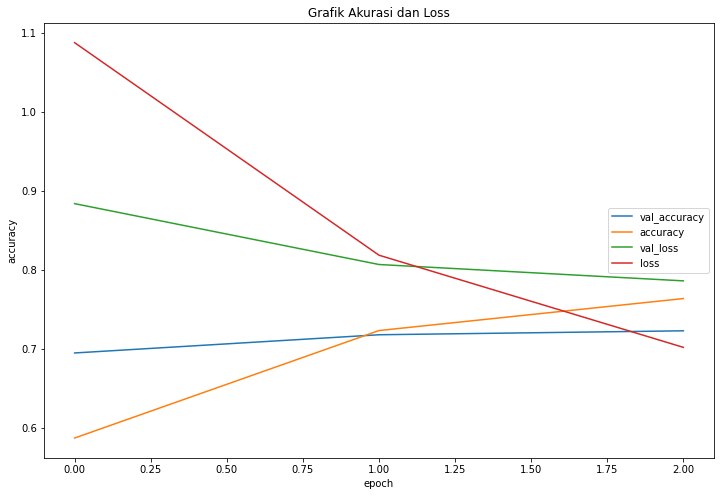

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Grafik Akurasi dan Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'accuracy', 'val_loss', 'loss'], loc='right')
plt.show()

## Prediksi

In [ ]:
X_train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
data.abstract.loc[5]

'let omega subset mathbb bound domain satisfi ahaymantyp asymmetri condit let arbitrari bound domainref obstacl interest behaviour firstdirichlet eigenvalu lambda_ omega setminu first prove anupp bound lambda_ omega setminu term distanceof set set maimum point _ first dirichletground state phi_ lambda_ omega short directcorollari begin equat mu_omega ma_ lambda_ omegasetminu end equat larg enough term lambda_ omega maimiz set mu_omega close maimumpoint _ phi_ lambda_ second discuss distribut phi_ lambda_ omega theposs inscrib wavelength ball given point omega final specifi observ conv obstacl show thatif mu_omega suffici larg respect lambda_ omega maimiz mu_omega contain maimum point _ phi_ lambda_ omega'

In [ ]:
new_abstr = ['let omega subset mathbb bound domain satisfi ahaymantyp asymmetri condit let arbitrari bound domainref obstacl interest behaviour firstdirichlet eigenvalu lambda_ omega setminu first prove anupp bound lambda_ omega setminu term distanceof set set maimum point _ first dirichletground state phi_ lambda_ omega short directcorollari begin equat mu_omega ma_ lambda_ omegasetminu end equat larg enough term lambda_ omega maimiz set mu_omega close maimumpoint _ phi_ lambda_ second discuss distribut phi_ lambda_ omega theposs inscrib wavelength ball given point omega final specifi observ conv obstacl show thatif mu_omega suffici larg respect lambda_ omega maimiz mu_omega contain maimum point _ phi_ lambda_ omega']

In [ ]:
seq = tokenizer.texts_to_sequences(new_abstr)

In [ ]:
padded = pad_sequences(seq, maxlen=10000)

In [ ]:
pred = model.predict(padded)

In [ ]:
pred

array([[9.1680000e-03, 1.6252404e-02, 2.0396407e-04, 9.4992971e-01,
        2.4445860e-02]], dtype=float32)

In [ ]:
data.topic.unique()

array(['Computer Science', 'Math & Stats', 'Physics', 'AI/ML',
       'Computer Vision'], dtype=object)

In [ ]:
df_new.head()

,title,abstract,AI/ML,Computer Science,Computer Vision,Math & Stats,Physics
0,Reconstructing Subject-Specific Effect Maps,predict model allow subjectspecif infer analyz...,0,1,0,0,0
1,Rotation Invariance Neural Network,rotat invari translat invari great valu imager...,0,1,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,introduc develop notion spheric polyharmon ana...,0,0,0,1,0
3,A finite element approximation for the stochas...,stochast landaulifshitzgilbert llg equat coupl...,0,0,0,1,0
4,Comparative study of Discrete Wavelet Transfor...,fouriertransform infrar ftir spectra sampl pla...,0,1,0,0,0


In [ ]:
topic = ['AI/ML',	'Computer Science',	'Computer Vision',	'Math & Stats',	'Physics']

In [ ]:
print(topic[np.argmax(pred)])

Math & Stats


In [ ]:
data.loc[5]

title       On maximizing the fundamental frequency of the...
abstract    let omega subset mathbb bound domain satisfi a...
topic                                            Math & Stats
Name: 5, dtype: object

In [ ]:
def get_category(abstract):
  abstract = tokenizer.texts_to_sequences(abstract)
  abstract = pad_sequences(abstract, maxlen=10000)
  prediction = model.predict(abstract)
  print(np.argmax(prediction))
  print(topic[np.argmax(prediction)])

In [ ]:
text = "In this paper, we propose a general meta learning approach to computing approximate Nash equilibrium for finite n-player normal-form games. Unlike existing solutions that approximate or learn a Nash equilibrium from scratch for each of the games, our meta solver directly constructs a mapping from a game utility matrix to a joint strategy profile. The mapping is parameterized and learned in a self-supervised fashion by a proposed Nash equilibrium approximation metric without ground truth data informing any Nash equilibrium. As such, it can immediately predict the joint strategy profile that approximates a Nash equilibrium for any unseen new game under the same game distribution. Moreover, the meta-solver can be further fine-tuned and adaptive to a new game if iteration updates are allowed. We theoretically prove that our meta-solver is not affected by the non-smoothness of exact Nash equilibrium solutions, and derive a sample complexity bound to demonstrate its generalization ability across normal-form games. Experimental results demonstrate its substantial approximation power against other strong baselines in both adaptive and non-adaptive cases."
get_category([text])

3
Math & Stats


In [ ]:
text = """Let G be a complex reductive group and V a G-module. There is a natural moment mapping μ:V⊕V∗→g∗ and we denote μ−1(0) (the shell) by N. We find criteria for N to have rational singularities and for the categorical quotient N//G to have symplectic singularities, the latter results improving upon [HSS20]. It turns out that for "most" G-modules V, the shell N has rational singularities. For the case of direct sums of classical representations of the classical groups, N has rational singularities and N//G has symplectic singularities if N is a reduced and irreducible complete intersection. Another important special case is V=pg (the direct sum of p copies of the Lie algebra of G) where p≥2. We show that N has rational singularities and that N//G has symplectic singularities, improving upon results of [Bud19] and [AA16]. Let π=π1(Σ) where Σ is a closed Riemann surface of genus p≥2. Let G be semisimple and let Hom(π,G) and X(π,G) be the corresponding representation variety and character variety. We show that Hom(π,G) is a complete intersection with rational singularities and that X(π,G) has symplectic singularities. If p>2 or G contains no simple factor of rank 1, then the singularities of Hom(π,G) and X(π,G) are in codimension at least four and Hom(π,G) is locally factorial. If, in addition, G is simply connected, then X(π,G) is locally factorial."""
get_category([text])

4
Physics


In [ ]:
wordss = "In this work, stable and convergent numerical schemes on nonuniform time meshes are proposed, for the solution of distributed-order diffusion equations. The stability and convergence of the numerical methods are proven, and a set of numerical results illustrate that the use of particular nonuniform time meshes provides more accurate results than the use of a uniform mesh, in the case of nonsmooth solutions"
get_category([wordss])

3
Math & Stats


## Export

In [ ]:
!mkdir model

In [ ]:
import pickle

In [ ]:
pickle.dump(tokenizer, open("model/tokenizer_abstract.pkl", "wb"))

In [ ]:
from keras.models import load_model

In [ ]:
model.save('model/paper_abstract.h5')

## Test

In [ ]:
import numpy as np

from keras.models import load_model
import pickle

In [ ]:
# Tokenisasi
tokenizer = pickle.load(open("model/tokenizer_abstract.pkl", "rb"))

# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
model = load_model('model/paper_abstract.h5')

In [ ]:
topic = ['AI/ML',	'Computer Science',	'Computer Vision',	'Math & Stats',	'Physics']

In [ ]:
def get_category(abstract):
  abstract = tokenizer.texts_to_sequences(abstract)
  abstract = pad_sequences(abstract, maxlen=10000)
  prediction = model.predict(abstract)
  print(np.argmax(prediction))
  print(topic[np.argmax(prediction)])

In [ ]:
tex2 = "As computer vision has become a part of our daily life. Using smartphones features like face recognition is all a part of computer vision. In this paper, we will talk aboutCV or Computer Vision which is preferably used to read and display a video stream in real time through which one can access the web camera and using machine learning one can let their system learn through data sent by user or through datasets which is easily available on the internet and then system trains itself. After training part it is ready to solve the real life problems. But using both computer vision and machine learning at the same time is always a challenging task asone has to capture and another has to train the system at the same timeso that the system could be able to recognize the things to which they are trained is the most innovative work in this paper as we have to keep in mind that both the things should be done at the same time"
get_category([tex2])

2
Computer Vision
